In [1]:
!pip install -q transformers
!pip install -q gradio
!pip install -q timm
!pip install -q torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.8/857.8 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.2/92.2 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 37.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 3.7 MB

In [30]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import os
import gradio as gr

import torch
from transformers import SamModel, SamProcessor
from transformers import pipeline
from transformers.utils import logging
logging.set_verbosity_error()

## **Define Helper Functions**

In [3]:
def show_mask(mask, ax, random_color=False):

    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])

    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0],
               pos_points[:, 1],
               color='green',
               marker='*',
               s=marker_size,
               edgecolor='white',
               linewidth=1.25)
    ax.scatter(neg_points[:, 0],
               neg_points[:, 1],
               color='red',
               marker='*',
               s=marker_size,
               edgecolor='white',
               linewidth=1.25)


def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def show_mask_on_image(raw_image, mask, return_image=False):
    if not isinstance(mask, torch.Tensor):
      mask = torch.Tensor(mask)

    if len(mask.shape) == 4:
      mask = mask.squeeze()

    fig, axes = plt.subplots(1, 1, figsize=(15, 15))

    mask = mask.cpu().detach()
    axes.imshow(np.array(raw_image))
    show_mask(mask, axes)
    axes.axis("off")
    plt.show()

    if return_image:
      fig = plt.gcf()
      return fig2img(fig)

def show_pipe_masks_on_image(raw_image, outputs):
  plt.imshow(np.array(raw_image))
  ax = plt.gca()
  for mask in outputs["masks"]:
      show_mask(mask, ax=ax, random_color=True)
  plt.axis("off")
  plt.show()

## **Mask Generation with SlimSAM**

In [5]:
sam_pipe = pipeline("mask-generation", "Zigeng/SlimSAM-uniform-77")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/38.9M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

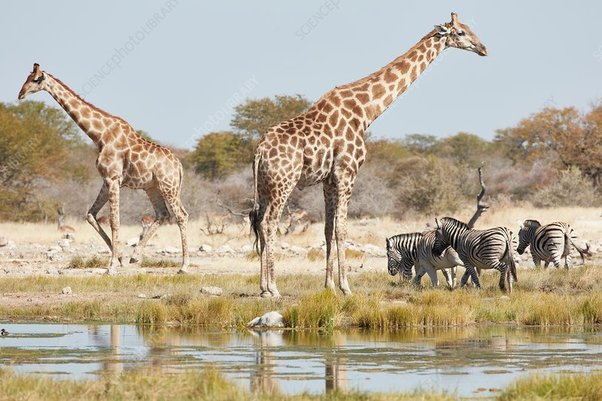

In [7]:
raw_image = Image.open('/content/wildlife.jpeg')
raw_image.resize((720, 375))
raw_image

In [8]:
raw_image.save("./mod.jpeg")

In [9]:
output = sam_pipe(raw_image, points_per_batch=32)

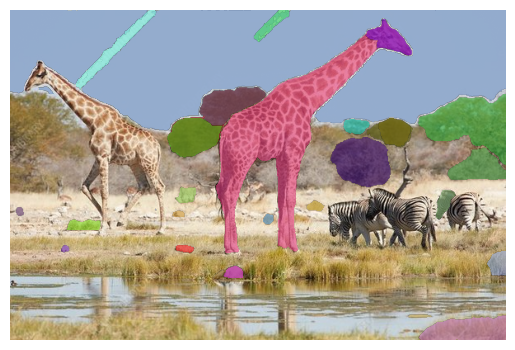

In [10]:
show_pipe_masks_on_image(raw_image, output)

## **Faster Inference: Infer an Image and a Single Point**

In [4]:
model = SamModel.from_pretrained("Zigeng/SlimSAM-uniform-77")

processor = SamProcessor.from_pretrained("Zigeng/SlimSAM-uniform-77")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/38.9M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [9]:
input_points = [[[460, 34]]]

In [10]:
inputs = processor(raw_image, input_points=input_points, return_tensors="pt")
inputs

{'pixel_values': tensor([[[[1.2043, 1.2043, 1.2043,  ..., 1.2214, 1.2214, 1.2214],
          [1.2043, 1.2043, 1.2043,  ..., 1.2214, 1.2214, 1.2214],
          [1.2043, 1.2043, 1.2043,  ..., 1.2214, 1.2214, 1.2214],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[1.5882, 1.5882, 1.5882,  ..., 1.6057, 1.6057, 1.6057],
          [1.5882, 1.5882, 1.5882,  ..., 1.6057, 1.6057, 1.6057],
          [1.5882, 1.5882, 1.5882,  ..., 1.6057, 1.6057, 1.6057],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[1.9603, 1.9603, 1.9603,  ..., 1.9777, 1.9777, 1.9777],
          [1.9603, 1.9603, 1.9603,  ..., 1.9777, 1.9777, 1.9777],
          [1.9603, 1.9603

In [11]:
# Get output from model.

with torch.no_grad():
    outputs = model(**inputs)

In [12]:
predicted_masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"]
)
predicted_masks

[tensor([[[[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False]],
 
          [[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False]],
 
          [[False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           [False, False, False,  ..., False, False, False],
           ...,
           [False, False, False

In [13]:
len(predicted_masks)

1

In [14]:
predicted_mask = predicted_masks[0]
predicted_mask.shape

torch.Size([1, 3, 401, 602])

In [15]:
outputs.iou_scores

tensor([[[0.8619, 0.8726, 0.8191]]])

In [16]:
for i in range(3):
    show_mask_on_image(raw_image, predicted_mask[:, i])

Output hidden; open in https://colab.research.google.com to view.

## **Depth Estimation with DPT**

In [18]:
depth_estimator = pipeline(task="depth-estimation", model="Intel/dpt-hybrid-midas")

config.json:   0%|          | 0.00/9.88k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/490M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

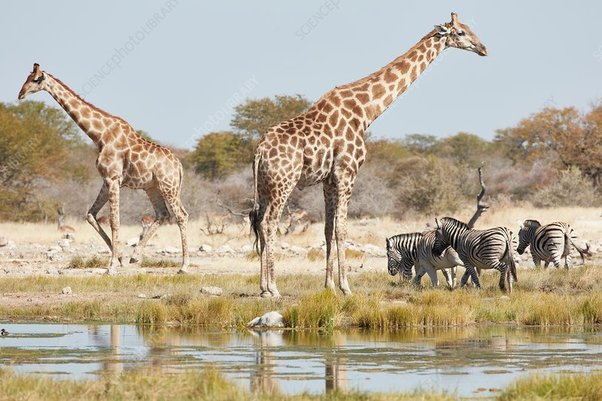

In [17]:
raw_image = Image.open('wildlife.jpeg')
raw_image.resize((806, 621))
raw_image

In [19]:
output = depth_estimator(raw_image)
output

{'predicted_depth': tensor([[[   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          ...,
          [2512.0315, 2517.6230, 2513.4531,  ..., 2468.4446, 2462.1528,
           2461.6177],
          [2527.2590, 2525.5859, 2526.0403,  ..., 2471.9658, 2476.7354,
           2464.5557],
          [2525.3120, 2532.5896, 2526.9080,  ..., 2487.3530, 2486.0576,
           2478.6013]]]),
 'depth': <PIL.Image.Image image mode=L size=602x401>}

In [20]:
output["predicted_depth"].shape

torch.Size([1, 384, 384])

In [21]:
output["predicted_depth"].unsqueeze(1).shape

torch.Size([1, 1, 384, 384])

In [22]:
prediction = torch.nn.functional.interpolate(
    output["predicted_depth"].unsqueeze(1),
    size=raw_image.size[::-1],
    mode="bicubic",
    align_corners=False,
)

In [23]:
prediction.shape

torch.Size([1, 1, 401, 602])

In [24]:
raw_image.size[::-1],

((401, 602),)

In [25]:
prediction

tensor([[[[   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
              0.0000],
          ...,
          [2513.4871, 2516.4922, 2518.8755,  ..., 2464.1616, 2462.2065,
           2461.7480],
          [2527.9370, 2527.0803, 2526.2092,  ..., 2478.1008, 2471.4180,
           2464.2573],
          [2524.6082, 2529.1204, 2532.6086,  ..., 2486.6396, 2482.0308,
           2478.1428]]]])

In [27]:
output = prediction.squeeze().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [252, 252, 253, ..., 247, 247, 247],
       [253, 253, 253, ..., 248, 248, 247],
       [253, 254, 254, ..., 249, 249, 248]], dtype=uint8)
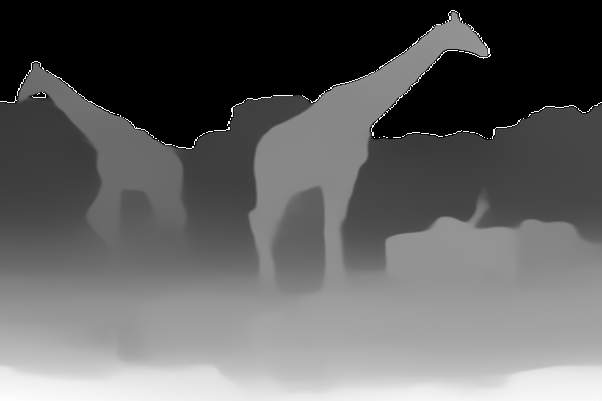

In [29]:
formatted

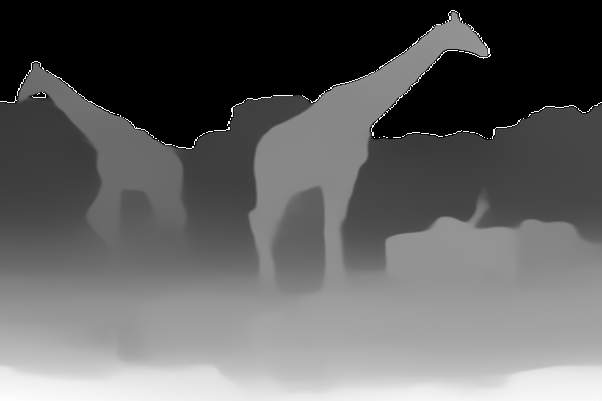

In [28]:
depth

## **Demo using Gradio**

In [32]:
def launch(input_image):

    out = depth_estimator(input_image)

    # resize the prediction
    prediction = torch.nn.functional.interpolate(
        out["predicted_depth"].unsqueeze(1),
        size=input_image.size[::-1],
        mode="bicubic",
        align_corners=False,
    )

    # normalize the prediction
    output = prediction.squeeze().numpy()
    formatted = (output * 255 / np.max(output)).astype("uint8")
    depth = Image.fromarray(formatted)

    return depth

In [33]:
iface = gr.Interface(launch, inputs=gr.Image(type='pil'), outputs=gr.Image(type='pil'))
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5e74ed62d14b304502.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [34]:
iface.close()

Closing server running on port: 7860
